In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import os 

In [4]:
from glob import glob

In [5]:
files = ['./train_set/00/*','./train_set/01/*','./train_set/02/*','./train_set/03/*','./train_set/04/*','./train_set/05/*','./train_set/06/*','./train_set/07/*','./train_set/08/*','./train_set/09/*','./train_set/10/*']

In [6]:
def get_training_data(file_array: list):
    training_data = []
   
    #looping through files array
    for file in file_array:
        #getting the image data
        image = tf.keras.utils.load_img(file, grayscale=False, color_mode='grayscale', target_size=None,interpolation='nearest')
        #converting everything to numpy array
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr]) 
        #normalize the array to a float from 0 to 1
        input_arr = input_arr/255
        #add dice image to training data
        training_data.append(input_arr[0])

    dices_array = np.array(training_data)
    return dices_array



In [7]:

def plot_history(history : tf.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')




In [8]:

def get_all_dices(files: list):
    dices = []
    for file in files:
        f = glob(file)
        dices.append(get_training_data(f))
    return dices

In [9]:
dices = get_all_dices(files)

In [10]:
for i in dices:
    print(i.shape)

(737, 128, 128, 1)
(540, 128, 128, 1)
(484, 128, 128, 1)
(606, 128, 128, 1)
(624, 128, 128, 1)
(932, 128, 128, 1)
(906, 128, 128, 1)
(413, 128, 128, 1)
(398, 128, 128, 1)
(511, 128, 128, 1)
(420, 128, 128, 1)


In [11]:
#normalizing the amount of dices
_MAX_SAMPLES = 398
_dices = []
for dice in dices:
    _dices.append(dice[:_MAX_SAMPLES])

In [12]:
def get_labels(max):
    labels = []
    for i in range(11):
        for j in range(max):
            labels.append(i)
    arr = np.array(labels)
    arr = arr.reshape((-1,1))
    return arr



In [13]:
def stack_training_data(_dices: list):
    training_data = np.concatenate([_dices[0],_dices[1]])
    for i in range(2,11):
        training_data = np.concatenate([training_data,_dices[i]])
    return training_data

In [14]:
#getting the labels for the training data
labels = get_labels(_MAX_SAMPLES)
labels.shape

(4378, 1)

In [15]:
#getting all the training data
_training_data = stack_training_data(_dices)
_training_data.shape

(4378, 128, 128, 1)

In [16]:
#getting the train and validation data
from sklearn.model_selection import train_test_split
train_val_drawings, test_drawings, train_val_labels, test_labels = train_test_split(
    _training_data, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_drawings, val_drawings, train_labels, val_labels = train_test_split(
    train_val_drawings, 
    train_val_labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)


In [17]:
print("train_drawings shape : ", train_drawings.shape)
print("val_drawings shape : ", val_drawings.shape)
print("test_drawings shape : ", test_drawings.shape)

print("train_labels shape : ", train_labels.shape)
print("val_labels shape : ", val_labels.shape)
print("test_labels shape : ", test_labels.shape)

train_drawings shape :  (2801, 128, 128, 1)
val_drawings shape :  (701, 128, 128, 1)
test_drawings shape :  (876, 128, 128, 1)
train_labels shape :  (2801, 1)
val_labels shape :  (701, 1)
test_labels shape :  (876, 1)


In [18]:
#parameters
input_size = 128
filter = 64

strides = (2, 2)
pool_size = (2,2)
kernel_size = (5, 5)

In [25]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(filters=filter,kernel_size=kernel_size,activation='relu',input_shape=(input_size,input_size,1)),
    

    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(filters=32,kernel_size=kernel_size,activation='relu'),
    

    layers.MaxPooling2D(pool_size=pool_size),
    
    layers.Dense(2,activation='Softmax')

])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dense_2 (Dense)             (None, 29, 29, 2)         66        
                                                                 
Total params: 52,962
Trainable params: 52,962
Non-trai

In [26]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(train_drawings,train_labels,epochs=10,validation_data=(val_drawings,val_labels))

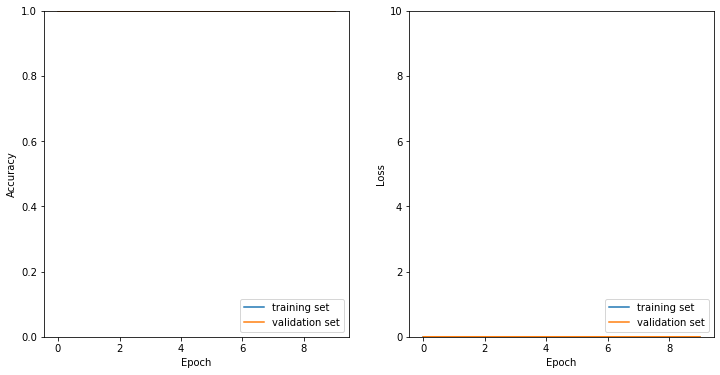

In [157]:
plot_history(history)

In [158]:
evaluation = model.evaluate(test_drawings,test_labels)

7/7 [==============================] - 0s 40ms/step - loss: 0.0017 - accuracy: 1.0000
